## Info
* Data = `bloomberg_usd_idr_2012_2024_processed.csv`

In [1]:
import pandas as pd
import numpy as np
import datetime
import time

import torch
from torch import nn

import matplotlib.pyplot as plt

In [2]:
# Read data
df = pd.read_csv('bloomberg_usd_idr_2012_2024_processed.csv')

df

,date,open,high,low,close,gap_day,next_close,open_change,high_change,low_change,...,ma_close_5,ma_close_10,prev_open,prev_high,prev_low,prev_close,daily_range,gap_change,close_ma5_ratio,close_ma10_ratio
0,2012-01-02,9150.0,9200.0,9067.0,9080.0,1,9135.0,50.0,-8.0,4.0,...,9074.000000,9070.833333,9100.0,9208.0,9063.0,9067.0,133.0,83.0,1.000661,1.001011
1,2012-01-03,9090.0,9185.0,9090.0,9135.0,1,9137.0,-60.0,-15.0,23.0,...,9094.000000,9080.000000,9150.0,9200.0,9067.0,9080.0,95.0,10.0,1.004508,1.006057
2,2012-01-04,9160.0,9185.0,9137.0,9137.0,1,9193.0,70.0,0.0,47.0,...,9117.333333,9087.125000,9090.0,9185.0,9090.0,9135.0,48.0,25.0,1.002157,1.005489
3,2012-01-05,9175.0,9203.0,9112.0,9193.0,1,9095.0,15.0,18.0,-25.0,...,9136.250000,9104.375000,9160.0,9185.0,9137.0,9137.0,91.0,38.0,1.006212,1.009734
4,2012-01-06,9178.0,9213.0,9095.0,9095.0,3,9150.0,3.0,10.0,-17.0,...,9128.000000,9106.875000,9175.0,9203.0,9112.0,9193.0,118.0,-15.0,0.996385,0.998696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3129,2024-10-21,15463.0,15498.0,15431.0,15495.0,1,15560.0,-60.0,-25.0,-16.0,...,15485.000000,15518.000000,15523.0,15523.0,15447.0,15465.0,67.0,-2.0,1.000646,0.998518
3130,2024-10-22,15534.0,15572.0,15534.0,15560.0,1,15620.0,71.0,74.0,103.0,...,15506.666667,15524.000000,15463.0,15498.0,15431.0,15495.0,38.0,39.0,1.003439,1.002319
3131,2024-10-23,15590.0,15633.0,15590.0,15620.0,1,15584.0,56.0,61.0,56.0,...,15558.333333,15536.000000,15534.0,15572.0,15534.0,15560.0,43.0,30.0,1.003964,1.005407
3132,2024-10-24,15640.0,15644.0,15580.0,15584.0,1,15640.0,50.0,11.0,-10.0,...,15564.750000,15539.000000,15590.0,15633.0,15590.0,15620.0,64.0,20.0,1.001237,1.002896


# ML Model

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)  # Set a seed for reproducibility
np.random.seed(42)      # Also set a seed for NumPy if you're using it

# Drop the 'date' column and separate 'next_close' as the target variable
features_df = df.drop(['date', 'next_close'], axis=1)
target_df = df['next_close']

# Do not apply scaling, using raw data directly

# Convert features and target into PyTorch tensors
X = torch.tensor(features_df.values, dtype=torch.float32)
y = torch.tensor(target_df.values, dtype=torch.float32).view(-1, 1)  # Ensure target is a 2D tensor

# Model definition
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

# Initialize the model, define the optimizer
input_size = X.shape[1]
model = LinearRegressionModel(input_size)
optimizer = optim.SGD(model.parameters(), lr=0.005)

# Weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# Sliding window training and validation
window_size = 30
all_losses = []

# Set this variable to control whether to limit the number of windows
set_limit = True  # Change this to False to process all windows
max_windows = 5  # Set your desired maximum number of windows if limiting is enabled

# Calculate the number of windows based on the dataset size
num_windows = len(X) - window_size

# If set_limit is True, apply the maximum window limit
if set_limit:
    num_windows = min(num_windows, max_windows)

for window_number in range(num_windows):
    start = window_number
    end = start + window_size
    X_train = X[start:end]
    y_train = y[start:end].view(-1, 1)
    X_val = X[end].unsqueeze(0)
    y_val = y[end].unsqueeze(0)

    model.train()
    for epoch in range(200):
        outputs = model(X_train)

        loss = nn.functional.mse_loss(outputs, y_train)  # MSE calculation

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val)
        val_loss = nn.functional.mse_loss(y_pred, y_val)  # Calculate MSE for validation
        rmse_loss = torch.sqrt(val_loss)  # Calculate RMSE
        all_losses.append(rmse_loss.item())

    print(f"Window {window_number + 1}: Training on rows {start} to {end - 1}, validating on row {end}.")
    print(f"Predicted value: {y_pred.item():.4f}, Actual value: {y_val.item():.4f}")
    print(f"Loss for this window (RMSE): {rmse_loss.item():.4f}")

# Calculate total average loss across all windows
average_loss = sum(all_losses) / len(all_losses)
print(f'Total Average Loss across first {num_windows} windows (RMSE): {average_loss:.4f}')

Window 1: Training on rows 0 to 29, validating on row 30.
Predicted value: 9039.2627, Actual value: 9030.0000
Loss for this window (RMSE): 9.2627
Window 2: Training on rows 1 to 30, validating on row 31.
Predicted value: 9072.7510, Actual value: 9032.0000
Loss for this window (RMSE): 40.7510
Window 3: Training on rows 2 to 31, validating on row 32.
Predicted value: 9145.1250, Actual value: 9090.0000
Loss for this window (RMSE): 55.1250
Window 4: Training on rows 3 to 32, validating on row 33.
Predicted value: 9088.6914, Actual value: 9046.0000
Loss for this window (RMSE): 42.6914
Window 5: Training on rows 4 to 33, validating on row 34.
Predicted value: 9081.5625, Actual value: 9026.0000
Loss for this window (RMSE): 55.5625
Total Average Loss across first 5 windows (RMSE): 40.6785


In [61]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)  # Set a seed for reproducibility
np.random.seed(42)      # Also set a seed for NumPy if you're using it

# Drop the 'date' column and separate 'next_close' as the target variable
features_df = df.drop(['date', 'next_close'], axis=1)
target_df = df['next_close']

# Do not apply scaling, using raw data directly

# Convert features and target into PyTorch tensors
X = torch.tensor(features_df.values, dtype=torch.float32)
y = torch.tensor(target_df.values, dtype=torch.float32).view(-1, 1)  # Ensure target is a 2D tensor

# Model definition
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

# Initialize the model, define the optimizer
input_size = X.shape[1]
model = LinearRegressionModel(input_size)
optimizer = optim.SGD(model.parameters(), lr=0.005)

# Weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# Specify the parameters for predictions and gaps
num_predictions = 3  # Specify how many rows you want to predict
gap = 1  # Specify the gap (number of rows to skip after each window)
window_size = 30  # Window size for training
max_windows = 10  # Set the maximum number of windows to process
set_limit = True  # Set this to False to process all windows
all_losses = []

# Calculate the number of windows based on the dataset size
num_windows = len(X) - window_size - num_predictions

# If set_limit is True, apply the maximum window limit
if set_limit:
    num_windows = min(num_windows, max_windows)

for window_number in range(num_windows):
    start = window_number
    end = start + window_size
    X_train = X[start:end]
    y_train = y[start:end].view(-1, 1)
    
    # Prepare validation data for prediction
    X_val = X[end:end + num_predictions]
    y_val = y[end:end + num_predictions].view(-1, 1)

    model.train()
    for epoch in range(200):
        outputs = model(X_train)

        loss = nn.functional.mse_loss(outputs, y_train)  # MSE calculation

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val)

        # Calculate RMSE for each predicted row and average them
        val_losses = [(torch.sqrt(nn.functional.mse_loss(y_pred[i].view(1, -1), y_val[i].view(1, -1)))).item() for i in range(num_predictions)]
        average_rmse_loss = sum(val_losses) / num_predictions  # Average RMSE for the current window
        all_losses.append(average_rmse_loss)

    print(f"Window {window_number + 1}: Training on rows {start} to {end - 1}, validating on rows {end} to {end + num_predictions - 1}.")
    print(f"Predicted values: {y_pred.squeeze().tolist()}, Actual values: {y_val.squeeze().tolist()}")
    print(f"Average Loss for this window (RMSE): {average_rmse_loss:.4f}")

    # Move to the next window based on the gap
    window_number += gap

# Calculate total average loss across all windows
total_average_loss = sum(all_losses) / len(all_losses)
print(f'Total Average Loss across first {num_windows} windows (RMSE): {total_average_loss:.4f}')

Window 1: Training on rows 0 to 29, validating on rows 30 to 32.
Predicted values: [9039.2626953125, 9072.6630859375, 9145.193359375], Actual values: [9030.0, 9032.0, 9090.0]
Average Loss for this window (RMSE): 35.0397
Window 2: Training on rows 1 to 30, validating on rows 31 to 33.
Predicted values: [9072.7509765625, 9145.146484375, 9088.291015625], Actual values: [9032.0, 9090.0, 9046.0]
Average Loss for this window (RMSE): 46.0628
Window 3: Training on rows 2 to 31, validating on rows 32 to 34.
Predicted values: [9145.125, 9088.5009765625, 9081.5732421875], Actual values: [9090.0, 9046.0, 9026.0]
Average Loss for this window (RMSE): 51.0664
Window 4: Training on rows 3 to 32, validating on rows 33 to 35.
Predicted values: [9088.69140625, 9081.5830078125, 9052.9931640625], Actual values: [9046.0, 9026.0, 9050.0]
Average Loss for this window (RMSE): 33.7559
Window 5: Training on rows 4 to 33, validating on rows 34 to 36.
Predicted values: [9081.560546875, 9052.9775390625, 9046.711914

## Parameter Tuning

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

torch.manual_seed(42)  # Set a seed for reproducibility
np.random.seed(42) 

# Drop the 'date' column and separate 'next_close' as the target variable
features_df = df.drop(['date', 'next_close'], axis=1)
target_df = df['next_close']

# Convert features and target into PyTorch tensors
X = torch.tensor(features_df.values, dtype=torch.float32)
y = torch.tensor(target_df.values, dtype=torch.float32).view(-1, 1)  # Ensure target is a 2D tensor

# Model definition
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

# Hyperparameters to tune
learning_rates = [0.003, 0.005, 0.007]
batch_sizes = [16, 32, 64]
num_epochs = [150, 200, 250]

results = []

# Loop through each combination of hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in num_epochs:
            model = LinearRegressionModel(input_size)
            optimizer = optim.SGD(model.parameters(), lr=lr)

            all_losses = []
            window_size = 30  # Set your desired window size
            num_windows = len(X) - window_size

            for window_number in range(num_windows):
                start = window_number
                end = start + window_size
                X_train = X[start:end]
                y_train = y[start:end].view(-1, 1)
                X_val = X[end:end + 3]  # Adjust for number of predictions
                y_val = y[end:end + 3].view(-1, 1)

                model.train()
                for epoch in range(epochs):
                    outputs = model(X_train)

                    loss = nn.functional.mse_loss(outputs, y_train)  # MSE calculation

                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()

                # Evaluate the model
                model.eval()
                with torch.no_grad():
                    y_pred = model(X_val)
                    val_loss = nn.functional.mse_loss(y_pred, y_val)  # Calculate MSE for validation
                    rmse_loss = torch.sqrt(val_loss)  # Calculate RMSE
                    all_losses.append(rmse_loss.item())

            # Calculate total average loss across all windows
            average_loss = sum(all_losses) / len(all_losses)
            results.append({'learning_rate': lr, 'batch_size': batch_size, 'number_of_epochs': epochs, 'total_avg_loss': average_loss})

# Convert results to DataFrame for easier handling and analysis
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

## to check

In [31]:
import pandas as pd

# Sample DataFrame creation (replace this with your actual DataFrame)
# df = pd.read_csv('your_data_file.csv')  # Load your DataFrame here

# Filter rows where 'gap_day' is greater than 5
filtered_rows = df[df['gap_day'] > 5]

# Find the index of the filtered rows
indices = filtered_rows.index

# Get the filtered rows and the next row
result = pd.concat([filtered_rows, df.loc[indices + 1]])

# Sort the result by index
result = result.sort_index()

# Display the result
result

,date,open,high,low,close,gap_day,next_close,open_change,high_change,low_change,close_change,ma_close_5,ma_close_10,prev_open,prev_high,prev_low,prev_close,daily_range,gap_change,close_ma5_ratio,close_ma10_ratio
406,2013-08-06,10280.0,10285.0,10280.0,10285.0,6,10290.0,5.0,-3.0,5.0,0.0,10285.000000,10279.000000,10275.0,10288.0,10275.0,10285.0,5.0,-5.0,1.000000,1.000584
407,2013-08-12,10270.0,10293.0,10270.0,10290.0,1,10290.0,-10.0,8.0,-10.0,5.0,10290.000000,10287.500000,10280.0,10285.0,10280.0,10285.0,23.0,-15.0,1.000000,1.000243
640,2014-07-25,11573.0,11616.0,11530.0,11578.0,6,11580.0,10.0,47.0,17.0,13.0,11564.600000,11602.250000,11563.0,11569.0,11513.0,11565.0,86.0,8.0,1.001159,0.997910
641,2014-07-31,11575.0,11580.0,11575.0,11580.0,1,11803.0,2.0,-36.0,45.0,2.0,11580.000000,11566.600000,11573.0,11616.0,11530.0,11578.0,5.0,-3.0,1.000000,1.001159
882,2015-07-15,13330.0,13367.0,13328.0,13346.0,7,13378.0,25.0,17.0,23.0,8.0,13328.666667,13333.375000,13305.0,13350.0,13305.0,13338.0,39.0,-8.0,1.001300,1.000947
883,2015-07-22,13350.0,13384.0,13341.0,13378.0,1,13421.0,20.0,17.0,13.0,32.0,13378.000000,13341.000000,13330.0,13367.0,13328.0,13346.0,43.0,4.0,1.000000,1.002773
1119,2016-07-01,13213.0,13213.0,13130.0,13138.0,10,13103.0,35.0,-7.0,-40.0,-82.0,13207.600000,13244.250000,13178.0,13220.0,13170.0,13220.0,83.0,-7.0,0.994730,0.991978
1120,2016-07-11,13113.0,13125.0,13100.0,13103.0,1,13120.0,-100.0,-88.0,-30.0,-35.0,13103.000000,13103.000000,13213.0,13213.0,13130.0,13138.0,25.0,-25.0,1.000000,1.000000
1355,2017-06-22,13308.0,13328.0,13300.0,13328.0,11,13368.0,0.0,6.0,10.0,9.0,13306.250000,13298.125000,13308.0,13322.0,13290.0,13319.0,28.0,-11.0,1.001635,1.002247
1356,2017-07-03,13300.0,13374.0,13300.0,13368.0,1,13364.0,-8.0,46.0,0.0,40.0,13368.000000,13368.000000,13308.0,13328.0,13300.0,13328.0,74.0,-28.0,1.000000,1.000000


In [34]:
import pandas as pd

# Assuming df is your DataFrame
# Filter for rows with gap_day > 5
filtered_df = df[df['gap_day'] > 5]

# Initialize a list to hold results
results = []

# Loop through the filtered DataFrame to get pairs of consecutive rows
for i in range(len(filtered_df) - 1):
    # Get the current and next row
    current_row = filtered_df.iloc[i]
    next_row = filtered_df.iloc[i + 1]

    # Calculate percentage differences based on the current row
    percent_change = {
        'gap_day': current_row['gap_day'],
        'open_percent_change': ((next_row['open'] - current_row['open']) / current_row['open']) * 100,
        'high_percent_change': ((next_row['high'] - current_row['high']) / current_row['high']) * 100,
        'low_percent_change': ((next_row['low'] - current_row['low']) / current_row['low']) * 100,
        'close_percent_change': ((next_row['close'] - current_row['close']) / current_row['close']) * 100,
    }
    results.append(percent_change)

# Create a DataFrame from the results
percent_changes_df = pd.DataFrame(results)

# Display the result
percent_changes_df

,gap_day,open_percent_change,high_percent_change,low_percent_change,close_percent_change
0,6,12.577821,12.941176,12.159533,12.571706
1,6,15.181889,15.074036,15.594102,15.270340
2,7,-0.877719,-1.152091,-1.485594,-1.558519
3,10,0.718989,0.870355,1.294745,1.446187
4,11,4.223024,4.621849,4.285714,4.516807
5,13,3.677001,3.377797,2.775775,2.462312
6,10,2.607789,2.518210,3.191863,3.061725
7,6,-0.420197,-0.534578,-0.577838,-0.577838
8,6,-3.355339,-3.306347,-2.974359,-2.919658
9,6,1.683099,2.040386,1.754757,2.105930


In [10]:
pd.set_option('display.max_rows', 40)

In [5]:
pd.set_option('display.max_columns', 25)

In [12]:
# Select only numeric columns for calculations
numeric_df = df.select_dtypes(include='number')

# Calculate descriptive statistics
stats = numeric_df.describe().T[['min', 'max', 'mean', 'std', '50%']].rename(columns={'50%': 'median'})
stats['variance'] = numeric_df.var()

# Calculate correlation with 'next_close'
correlations = numeric_df.corr()['next_close'].drop('next_close')

# Combine stats and correlations into one DataFrame
stats['correlation_with_next_close'] = correlations

# Display the results
stats

,min,max,mean,std,median,variance,correlation_with_next_close
open,8895.000000,16505.000000,13392.506701,1856.820019,13919.000000,3.447781e+06,0.999159
high,8960.000000,16625.000000,13424.632419,1854.367566,13946.500000,3.438679e+06,0.999360
low,8875.000000,16495.000000,13371.190172,1857.384269,13881.500000,3.449876e+06,0.999354
close,8935.000000,16575.000000,13396.277281,1856.472401,13914.000000,3.446490e+06,0.999562
gap_day,1.000000,13.000000,1.494257,1.008011,1.000000,1.016086e+00,0.021391
next_close,8935.000000,16575.000000,13398.397575,1855.335477,13915.000000,3.442270e+06,NaN
open_change,-403.000000,662.000000,2.081047,56.256876,4.000000,3.164836e+03,-0.000009
high_change,-412.000000,689.000000,2.053287,54.433314,2.000000,2.962986e+03,-0.000435
low_change,-439.000000,662.000000,2.086790,55.678419,5.000000,3.100086e+03,-0.000975
close_change,-452.000000,690.000000,2.097320,54.904389,2.000000,3.014492e+03,-0.002884


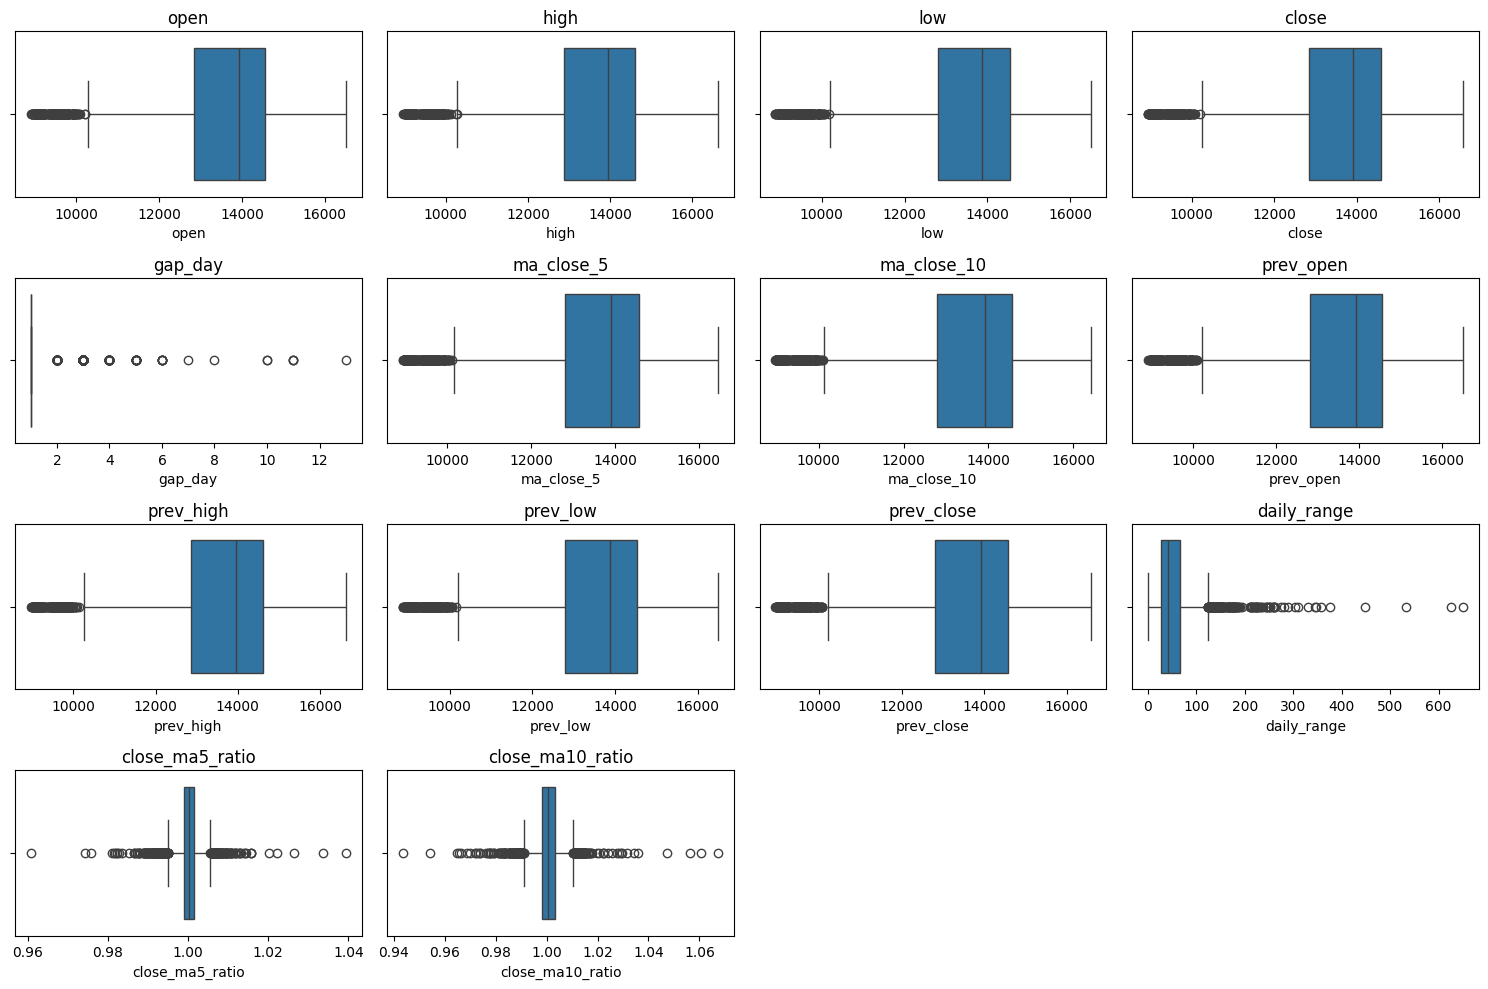

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create box plots for each relevant column
columns_to_check = [
    'open', 'high', 'low', 'close', 'gap_day', 
    'ma_close_5', 'ma_close_10', 'prev_open', 'prev_high', 
    'prev_low', 'prev_close', 'daily_range', 'close_ma5_ratio', 'close_ma10_ratio'
]

plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=df, x=column)
    plt.title(column)

plt.tight_layout()
plt.show()

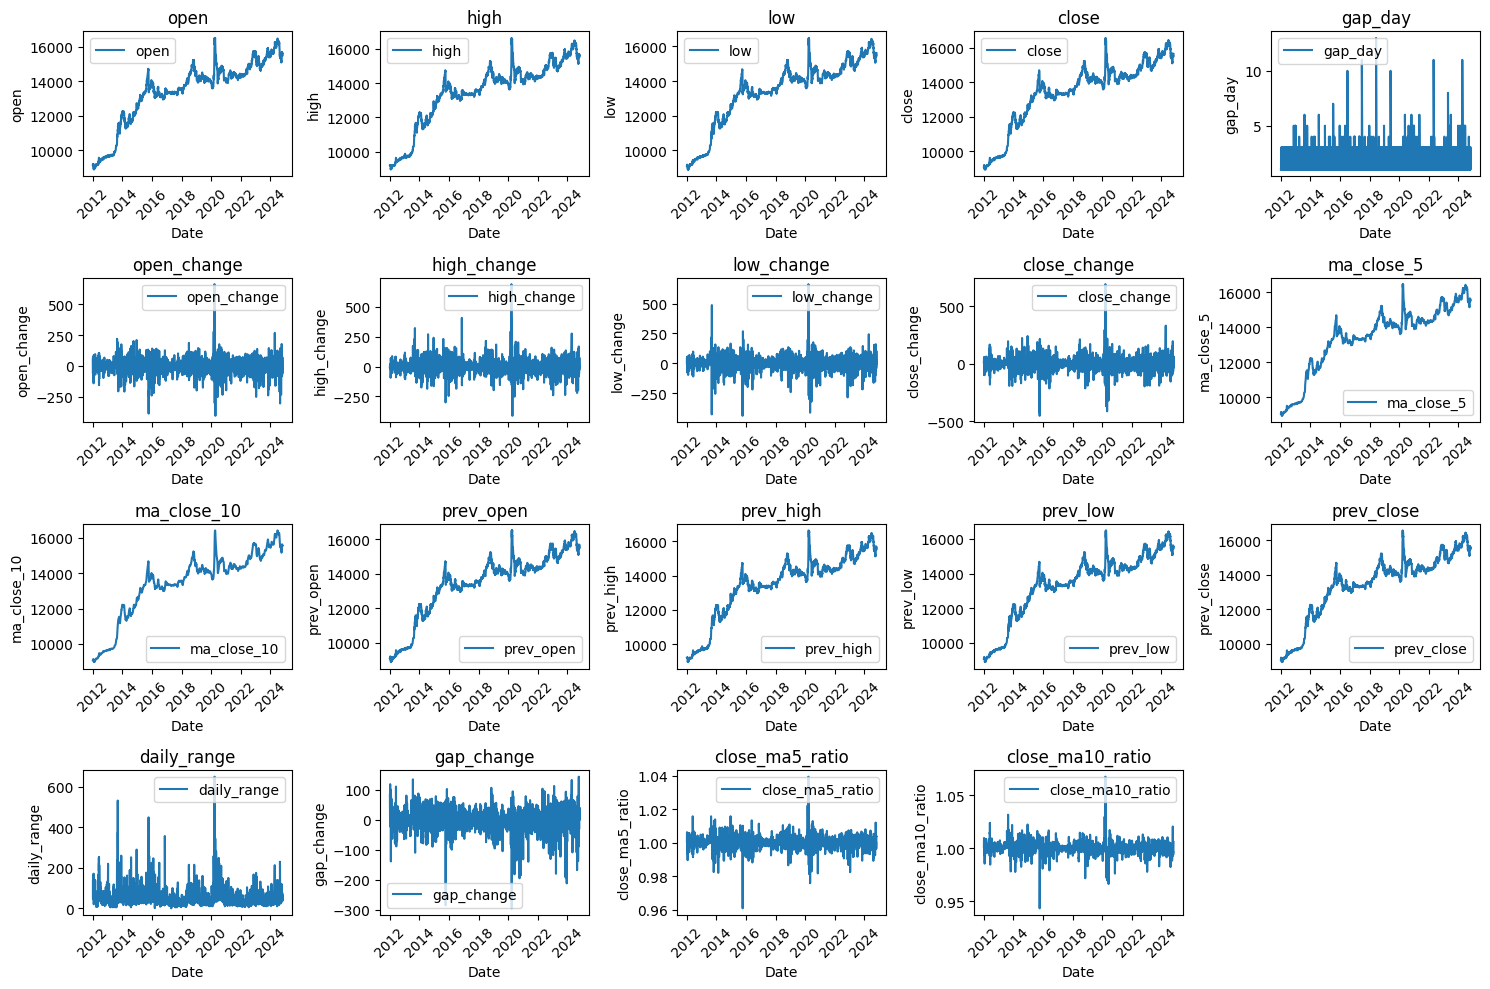

In [19]:
import matplotlib.pyplot as plt

# Convert 'date' column to datetime if not already in datetime format
df['date'] = pd.to_datetime(df['date'])

# Set the date column as the index for plotting
df.set_index('date', inplace=True)

# Define columns to plot
columns_to_plot = [
    'open', 'high', 'low', 'close', 'gap_day', 
    'open_change', 'high_change', 'low_change', 'close_change',
    'ma_close_5', 'ma_close_10', 'prev_open', 'prev_high', 
    'prev_low', 'prev_close', 'daily_range', 'gap_change', 
    'close_ma5_ratio', 'close_ma10_ratio'
]

# Plot each column
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(4, 5, i)  # Adjust the layout as necessary
    plt.plot(df.index, df[column], label=column)
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

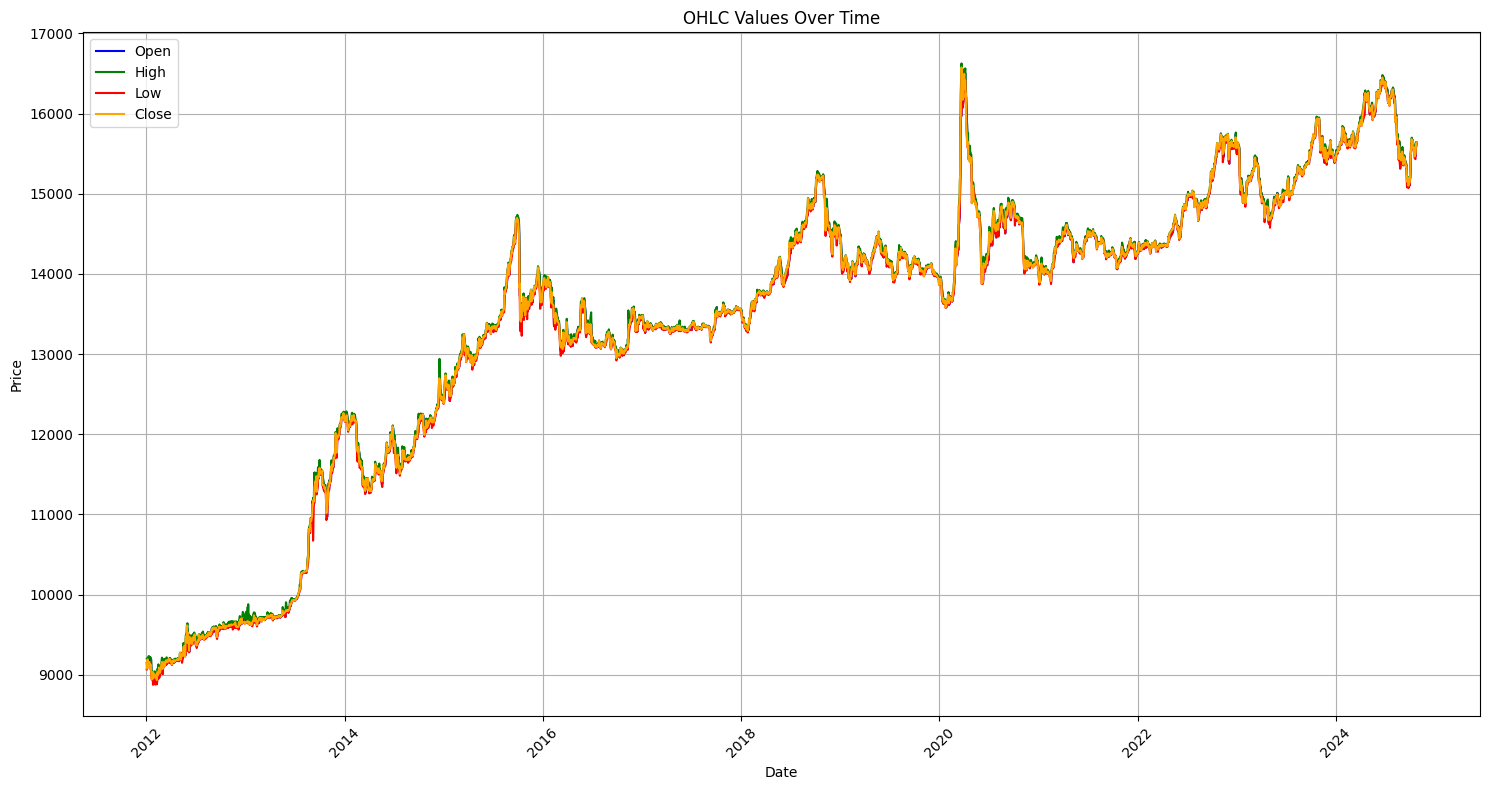

In [25]:
import matplotlib.pyplot as plt

# Ensure the date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Set 'date' as the index
df.set_index('date', inplace=True)

# Plot OHLC values
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['open'], label='Open', color='blue', linewidth=1.5)
plt.plot(df.index, df['high'], label='High', color='green', linewidth=1.5)
plt.plot(df.index, df['low'], label='Low', color='red', linewidth=1.5)
plt.plot(df.index, df['close'], label='Close', color='orange', linewidth=1.5)

# Customize the plot
plt.title('OHLC Values Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

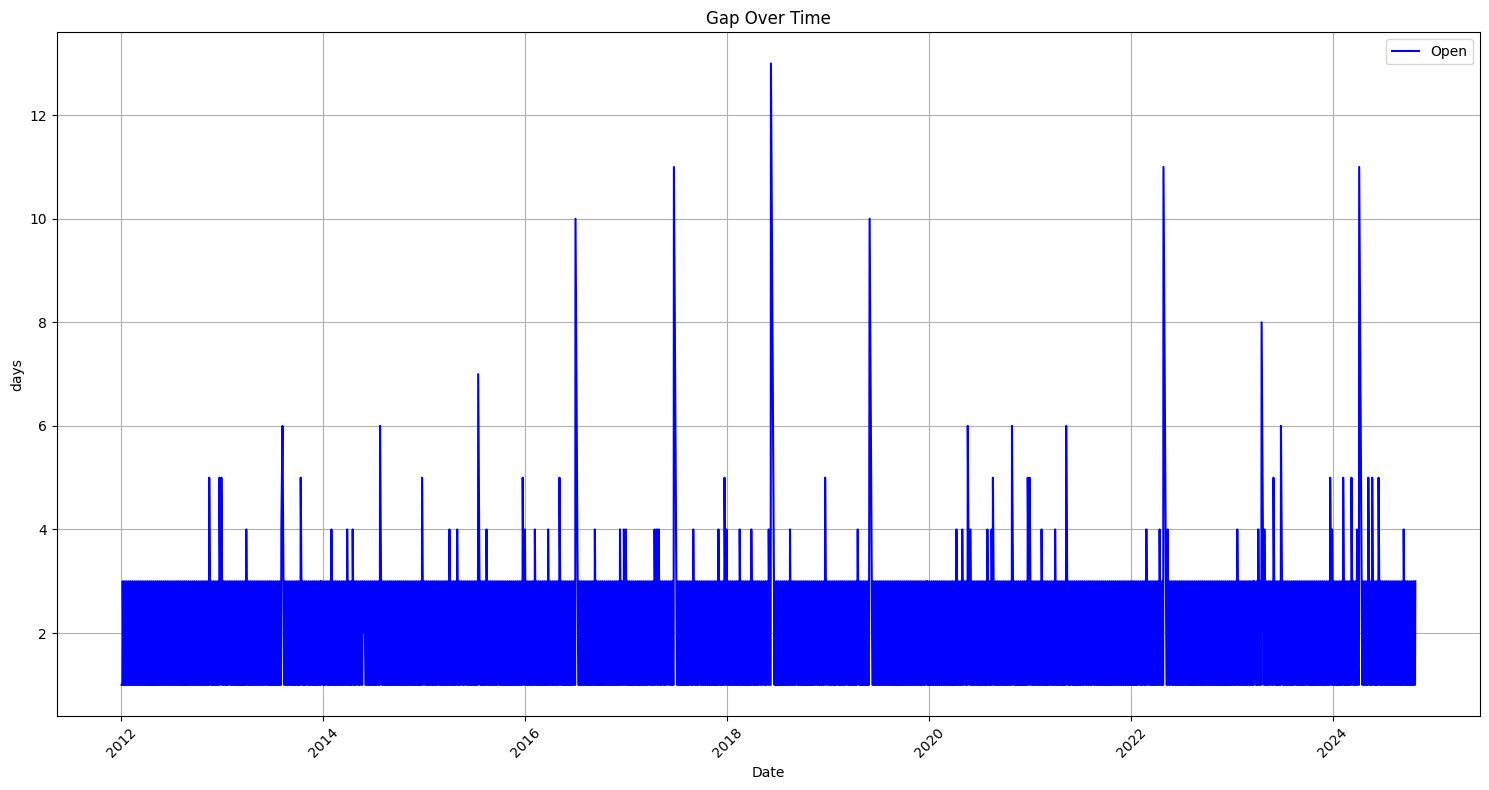

In [28]:
import matplotlib.pyplot as plt

# Ensure the date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Set 'date' as the index
df.set_index('date', inplace=True)

# Plot OHLC values
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['gap_day'], label='Open', color='blue', linewidth=1.5)

# Customize the plot
plt.title('Gap Over Time')
plt.xlabel('Date')
plt.ylabel('days')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

In [23]:
# Display the columns of the DataFrame
print(df.columns)

Index(['open', 'high', 'low', 'close', 'gap_day', 'next_close', 'open_change',
       'high_change', 'low_change', 'close_change', 'ma_close_5',
       'ma_close_10', 'prev_open', 'prev_high', 'prev_low', 'prev_close',
       'daily_range', 'gap_change', 'close_ma5_ratio', 'close_ma10_ratio'],
      dtype='object')
